In [1]:
%matplotlib inline

# An LSTM for Part-of-Speech Tagging
https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html


In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

### Load Data

In [3]:
import csv
Dataset = []
with open('Data/Parsed_simpletag.csv', newline='') as csvfile:
    csv_reader = csv.reader(csvfile, delimiter=',')
   
    data = []
    for row in csv_reader:
        
        if len(row) == 0:
            Dataset.append(data)
            data = []
        else:
            tag = [row[0], row[1], row[2]]
            data.append(tag)

### Make universal tagset!

In [4]:
# http://universaldependencies.org/u/pos/

uni = {
    # open
    'A': 'ADJ',
    'ADV': 'ADV',
    'INTJ': 'INTJ',
    'S': 'NOUN',
    'V': 'VERB',
    'INIT': 'PROPN', 
    
    # closed
    'PR': 'ADP',
    #'': 'AUX', ### not in Russian
    'CONJ': 'CONJ', # 'CCONJ', 'SCONJ'
    'APRO': 'DET',
    'NUM': 'NUM',
    'PART': 'PART',
    'SPRO': 'PRON',
    
    # other
    'PUNCT': 'PUNCT',
    'NONLEX': 'X',
        
    # dop
    'ADVPRO': 'ADV',
    'ANUM': 'ADJ',
    'PARENTH': 'ADV',  # Вводное слово
    'PRAEDIC': 'ADV',  # maybe VERB
    'PRAEDICPRO': 'ADV'  # maybe VERB
}

In [5]:
for sentence in Dataset:
    for word in sentence:
        
        tag = uni[word[2]]
        word.pop(2)
        word.append(tag)

## Prepare data!

In [6]:
def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)

In [7]:
use_lemms = 1

data = []
for sentence in Dataset:
    sentence_data = []
    words = []
    tags = []
    for word in sentence:
        words.append(word[use_lemms])
        tags.append(word[2])
    
    sentence_data.append(words)
    sentence_data.append(tags)
    
    sentence_data = tuple(sentence_data)
    data.append(sentence_data)
    
print('num of sentences:', len(data))

num of sentences: 87782


In [8]:
data[100:105]

[(['нет', '.'], ['PART', 'PUNCT']),
 (['один', 'только', 'кусочек', 'холодный', 'остаться', '.'],
  ['ADJ', 'PART', 'NOUN', 'ADJ', 'VERB', 'PUNCT']),
 (['В', '..'], ['PROPN', 'PUNCT']),
 (['давайте', 'погреть', '.'], ['PART', 'VERB', 'PUNCT']),
 (['Б', '..'], ['PROPN', 'PUNCT'])]

## Make w2v!!!

In [9]:
import gensim
from pymystem3 import Mystem
#import pymorphy2
from ufal.udpipe import Model, Pipeline

word_vectors = gensim.models.KeyedVectors.load_word2vec_format("/home/r/Documents/data_w2v/tenth.norm-sz500-w7-cb0-it5-min5.w2v", 
                                                               binary=True, unicode_errors='ignore')

print(word_vectors.vectors.shape)

(2641862, 500)


In [10]:
path = 'udpipes/'
modelfile1 = 'russian-syntagrus-ud-2.3-181115.udpipe'
modelfile2 = 'russian-gsd-ud-2.3-181115.udpipe'
modelfile3 = 'russian-taiga-ud-2.3-181115.udpipe'

model1 = Model.load(path + modelfile1)
model2 = Model.load(path + modelfile2)
model3 = Model.load(path + modelfile3)

In [11]:
def tag_ufal(word, model):
    
    pipeline = Pipeline(model, 'tokenize', Pipeline.DEFAULT, Pipeline.DEFAULT, 'conllu')
    processed = pipeline.process(word)
    output = [l for l in processed.split('\n') if not l.startswith('#')]
    tagged = ['_'.join(w.split('\t')[2:4]) for w in output if w]
    tagged = [w.split('\t')[2] for w in output if w]

    if len(tagged) > 1:
        pass
        #print('MANY tags!')
        #print(word, tagged)
    return tagged[0]

In [12]:
word_vectors['vector'][:50]

array([-0.18125933,  0.04451561,  0.04566395, -0.08743411,  0.06082746,
        0.3114289 , -0.27108607,  0.12590593,  0.27222472,  0.4354773 ,
       -0.14616688, -0.1757782 ,  0.0132714 , -0.15076365,  0.07179581,
       -0.16493756, -0.03184904, -0.39687994,  0.02206128, -0.0151894 ,
       -0.08458586, -0.12455434,  0.08239872,  0.15433611,  0.36637557,
       -0.14813724, -0.00548346,  0.0207062 , -0.11735547, -0.07771657,
       -0.23354442, -0.05254282, -0.01529887, -0.00365412,  0.05576355,
        0.10970679, -0.06045992,  0.2756294 ,  0.35827807,  0.19157635,
       -0.15099981, -0.04767626,  0.11978843, -0.1600945 , -0.21727917,
       -0.10526314,  0.14590985, -0.3157325 , -0.00958069,  0.1108558 ],
      dtype=float32)

### extract vectors!

In [13]:
repair = {
    '0': 'ноль',
    '1': 'один',
    '2': 'два',
    '3': 'три',
    '4': 'четыре',
    '5': 'пять',
    '6': 'шесть',
    '7': 'семь',
    '8': 'восемь',
    '9': 'девять',
    '10': 'десять',
    ':': '-',
    ';': ',',
    ':"': '-',
    
}

In [14]:
w2v_data = []

faild_words = []
faild_tags = []

for i, sentence in enumerate(data):
    
    if i % 5000 == 0:
        print('iter =', i)
    #print(sentence)
    
    flag = True
    
    new_sentence = []
    for i, word in enumerate(sentence[0]):
        
        word = word.lower()
        
        # repair some words!
        if word in list(repair.keys()):
            word = repair[word]
        if word.count('-') == 1 and len(word) != 1:
            ind = word.index('-')
            word = word[:ind] + word[ind + 1:]
            
        for letter in word:
            if ord(letter) >= 97 and ord(letter) <= 122 or \
            ord(letter) >= 65 and ord(letter) <= 90:
                word = 'vector'
        
        # try-excepts for
        try:
            word_vectors[word]
            new_sentence.append(word)
            
        except KeyError:
            try:
                tag = tag_ufal(word, model1)
                word_vectors[tag]
                new_sentence.append(tag)
            except KeyError:
                try:
                    tag = tag_ufal(word, model2)
                    word_vectors[tag]
                    new_sentence.append(tag)
                except KeyError:
                    try:
                        tag = tag_ufal(word, model3)
                        word_vectors[tag]
                        new_sentence.append(tag)
                    except KeyError:
                        faild_words.append(word)
                        faild_tags.append(sentence[1][i])
                        flag = False
    
    if flag == True:
        w2v_data.append((new_sentence, sentence[1]))


iter = 0
iter = 5000
iter = 10000
iter = 15000
iter = 20000
iter = 25000
iter = 30000
iter = 35000
iter = 40000
iter = 45000
iter = 50000
iter = 55000
iter = 60000
iter = 65000
iter = 70000
iter = 75000
iter = 80000
iter = 85000


In [15]:
data = w2v_data
len(data)

77098

## REAPIR!

In [16]:
# create dicts!

failw = {}
for fail in faild_words:
    try:
        failw[fail] += 1
    except:
        failw[fail] = 1     
        
failt = {}
for fail in faild_tags:
    try:
        failt[fail] += 1
    except:
        failt[fail] = 1

In [17]:
sorted_x = sorted(failw.items(), key=lambda kv: kv[1], reverse=True)
sorted_x[:10]

[('«', 528),
 ('»', 235),
 ('20', 225),
 ('12', 214),
 ('15', 206),
 ('2002', 202),
 ('2003', 184),
 ('30', 179),
 ('11', 177),
 ('50', 154)]

In [18]:
sorted_y = sorted(failt.items(), key=lambda kv: kv[1], reverse=True)
sorted_y

[('NUM', 8628),
 ('NOUN', 3261),
 ('ADJ', 2725),
 ('PUNCT', 1707),
 ('VERB', 305),
 ('ADV', 103),
 ('X', 80),
 ('PART', 27),
 ('INTJ', 19),
 ('DET', 6),
 ('PRON', 1)]

In [19]:
# create dicts!

tag_count = {}
for sent, tags in data:

    for tag in tags:
        
        try:
            tag_count[tag] += 1
        except:
            tag_count[tag] = 1       


In [20]:
tag_count

{'PUNCT': 203016,
 'NUM': 12909,
 'VERB': 121230,
 'NOUN': 214176,
 'ADV': 62094,
 'PART': 36821,
 'CONJ': 60130,
 'DET': 37938,
 'PRON': 62164,
 'ADJ': 68525,
 'ADP': 75795,
 'INTJ': 884,
 'PROPN': 2255,
 'X': 4467}

### Train_test split

In [21]:
# create dicts!

word_to_ix = {}
tag_to_ix = {}
for sent, tags in data:
    for word in sent:
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)
            
    for tag in tags:
        if tag not in tag_to_ix:
            tag_to_ix[tag] = len(tag_to_ix)        
print(len(word_to_ix), len(tag_to_ix))

37045 14


In [23]:
from sklearn.model_selection import train_test_split
num_of_test = 0.2

train_data, test_data = train_test_split(data, test_size = num_of_test, random_state = 12345)
print(len(train_data), len(test_data))

61678 15420


# Train the model:



In [24]:
class LSTMTagger(nn.Module):

    def __init__(self, hidden_dim1, hidden_dim2, tagset_size):
        super(LSTMTagger, self).__init__()
        self.hidden_dim1 = hidden_dim1
        self.hidden_dim2 = hidden_dim2
        
        #self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim1.
        self.lstm = nn.LSTM(500, hidden_dim1, bidirectional=True)

        self.lstm2 = nn.LSTM(hidden_dim1 * 2, hidden_dim2, bidirectional=True)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(hidden_dim2 * 2, tagset_size)
        self.hidden1 = self.init_hidden1()
        self.hidden2 = self.init_hidden2()

    def init_hidden1(self):

        return (torch.zeros(2, 1, self.hidden_dim1),
                torch.zeros(2, 1, self.hidden_dim1))

    def init_hidden2(self):

        return (torch.zeros(2, 1, self.hidden_dim2),
                torch.zeros(2, 1, self.hidden_dim2))

    def forward(self, sentence):
        
        lstm_out, self.hidden = self.lstm(
            sentence, self.hidden1)

        lstm_out2, self.hidden = self.lstm2(
            lstm_out.view(len(sentence), 1, -1), self.hidden2)

        tag_space = self.hidden2tag(lstm_out2.view(len(sentence), -1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores

## Funcs

In [25]:
def train(sentence, tag):
    model.zero_grad()

    sentence_in = torch.Tensor(word_vectors[sentence])
    sentence_in = sentence_in.view(len(sentence), 1, -1)
    
    targets = prepare_sequence(tag, tag_to_ix)

    # forward pass
    tag_scores = model(sentence_in)

    # loss and backward
    loss = loss_function(tag_scores, targets)
    
    loss.backward()
    
    loss.detach_()
    optimizer.step()
        
    return tag_scores, loss

In [26]:
from sklearn.metrics import accuracy_score

def evaluate(num_iter = 100):
    with torch.no_grad():
        
        main_score = 0
        for i in range(num_iter):
            rng = np.random.randint(len(test_data))
            
            sentence = test_data[rng][0]
            
            sentence_in = torch.Tensor(word_vectors[sentence])
            sentence_in = sentence_in.view(len(sentence), 1, -1)

            output = model(sentence_in)
            
            # get top
            topv, topi = output.topk(1)
            true_values = prepare_sequence(test_data[rng][1], tag_to_ix)

            score = accuracy_score(true_values, topi)
            main_score += score

        
        return main_score / num_iter

In [27]:
def total_evaluate():
    with torch.no_grad():
        
        main_score = 0
        for i in range(len(test_data)):
            sentence = test_data[i][0]
            sentence_in = torch.Tensor(word_vectors[sentence])
            sentence_in = sentence_in.view(len(sentence), 1, -1)

            output = model(sentence_in)

            # get top
            topv, topi = output.topk(1)
            true_values = prepare_sequence(test_data[i][1], tag_to_ix)

            score = accuracy_score(true_values, topi)
            main_score += score

        
        return main_score / len(test_data)

In [28]:
def train_rng():
    
    rng = np.random.randint(len(train_data))
    
    sentence = train_data[rng][0]
    tag = train_data[rng][1]
    
    return sentence, tag

In [29]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

## GONNA TRAIN!

In [30]:
HIDDEN_DIM = 300
HIDDEN_DIM2 = 300

model = LSTMTagger(HIDDEN_DIM, HIDDEN_DIM2, len(tag_to_ix))
loss_function = nn.NLLLoss()

all_losses = []

In [31]:
learning_rate = 0.1

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

n_iters = 20000 

plot_every = 100
print_every = 300

current_loss = 0
start = time.time()

model.hidden1 = model.init_hidden1()
model.hidden2 = model.init_hidden2()

for i in range(1, n_iters + 1):
        
    se, tag = train_rng()
    out, loss = train(se, tag)
    current_loss += loss
    
    if i % print_every == 0:
        print('%d %d%% (%s) loss: %.4f accuracy on test: %.4f' % (i, i / n_iters * 100, 
                                                                  timeSince(start), current_loss / plot_every, evaluate()))
    
    if i % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

300 1% (0m 24s) loss: 2.1011 accuracy on test: 0.3114
600 3% (0m 52s) loss: 1.9640 accuracy on test: 0.3378
900 4% (1m 22s) loss: 1.6343 accuracy on test: 0.4528
1200 6% (1m 49s) loss: 1.3471 accuracy on test: 0.5307
1500 7% (2m 15s) loss: 1.0850 accuracy on test: 0.6533
1800 9% (2m 42s) loss: 0.8184 accuracy on test: 0.7953
2100 10% (3m 9s) loss: 0.5965 accuracy on test: 0.8146
2400 12% (3m 36s) loss: 0.5747 accuracy on test: 0.8309
2700 13% (4m 5s) loss: 0.4380 accuracy on test: 0.8707
3000 15% (4m 32s) loss: 0.4132 accuracy on test: 0.8987
3300 16% (4m 58s) loss: 0.3027 accuracy on test: 0.8904
3600 18% (5m 24s) loss: 0.3471 accuracy on test: 0.8765
3900 19% (5m 53s) loss: 0.2798 accuracy on test: 0.9099
4200 21% (6m 27s) loss: 0.2311 accuracy on test: 0.9321
4500 22% (6m 57s) loss: 0.2018 accuracy on test: 0.9546
4800 24% (7m 26s) loss: 0.2131 accuracy on test: 0.9361
5100 25% (7m 56s) loss: 0.1745 accuracy on test: 0.9449
5400 27% (8m 25s) loss: 0.1456 accuracy on test: 0.9442
570

0.9681596048194253


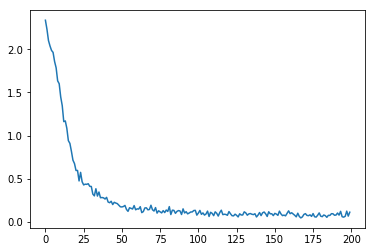

In [32]:
import matplotlib.pyplot as plt

print(total_evaluate())

plt.plot(all_losses)
plt.show()

In [36]:
learning_rate = 0.05

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

n_iters = 15000 

plot_every = 100
print_every = 300

current_loss = 0
start = time.time()

model.hidden1 = model.init_hidden1()
model.hidden2 = model.init_hidden2()

for i in range(1, n_iters + 1):
        
    se, tag = train_rng()
    out, loss = train(se, tag)
    current_loss += loss
    
    if i % print_every == 0:
        print('%d %d%% (%s) loss: %.4f accuracy on test: %.4f' % (i, i / n_iters * 100, 
                                                                  timeSince(start), current_loss / plot_every, evaluate()))
    
    if i % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

300 2% (0m 29s) loss: 0.0758 accuracy on test: 0.9782
600 4% (0m 55s) loss: 0.0768 accuracy on test: 0.9768
900 6% (1m 21s) loss: 0.0567 accuracy on test: 0.9769
1200 8% (1m 47s) loss: 0.0630 accuracy on test: 0.9734
1500 10% (2m 14s) loss: 0.0675 accuracy on test: 0.9726
1800 12% (2m 41s) loss: 0.0737 accuracy on test: 0.9700
2100 14% (3m 8s) loss: 0.0647 accuracy on test: 0.9839
2400 16% (3m 37s) loss: 0.0597 accuracy on test: 0.9891
2700 18% (4m 4s) loss: 0.0465 accuracy on test: 0.9861
3000 20% (4m 34s) loss: 0.1212 accuracy on test: 0.9832
3300 22% (5m 0s) loss: 0.0782 accuracy on test: 0.9830
3600 24% (5m 27s) loss: 0.0873 accuracy on test: 0.9813
3900 26% (5m 53s) loss: 0.0533 accuracy on test: 0.9848
4200 28% (6m 21s) loss: 0.0826 accuracy on test: 0.9785
4500 30% (6m 47s) loss: 0.0565 accuracy on test: 0.9676
4800 32% (7m 15s) loss: 0.1637 accuracy on test: 0.9715
5100 34% (7m 43s) loss: 0.0463 accuracy on test: 0.9827
5400 36% (8m 8s) loss: 0.0535 accuracy on test: 0.9761
570

0.9800449667464888


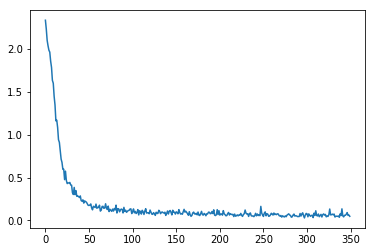

In [37]:
import matplotlib.pyplot as plt

print(total_evaluate())

plt.plot(all_losses)
plt.show()

In [38]:
learning_rate = 0.01

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

n_iters = 15000 

plot_every = 100
print_every = 300

current_loss = 0
start = time.time()

model.hidden1 = model.init_hidden1()
model.hidden2 = model.init_hidden2()

for i in range(1, n_iters + 1):
        
    se, tag = train_rng()
    out, loss = train(se, tag)
    current_loss += loss
    
    if i % print_every == 0:
        print('%d %d%% (%s) loss: %.4f accuracy on test: %.4f' % (i, i / n_iters * 100, 
                                                                  timeSince(start), current_loss / plot_every, evaluate()))
    
    if i % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

300 2% (0m 27s) loss: 0.1159 accuracy on test: 0.9834
600 4% (0m 57s) loss: 0.0487 accuracy on test: 0.9853
900 6% (1m 25s) loss: 0.0660 accuracy on test: 0.9818
1200 8% (1m 58s) loss: 0.0638 accuracy on test: 0.9828
1500 10% (2m 30s) loss: 0.0614 accuracy on test: 0.9765
1800 12% (3m 2s) loss: 0.0527 accuracy on test: 0.9843
2100 14% (3m 33s) loss: 0.0567 accuracy on test: 0.9732
2400 16% (4m 5s) loss: 0.0359 accuracy on test: 0.9816
2700 18% (4m 37s) loss: 0.0467 accuracy on test: 0.9796
3000 20% (5m 9s) loss: 0.0435 accuracy on test: 0.9828
3300 22% (5m 36s) loss: 0.0568 accuracy on test: 0.9755
3600 24% (6m 7s) loss: 0.0625 accuracy on test: 0.9846
3900 26% (6m 36s) loss: 0.0583 accuracy on test: 0.9787
4200 28% (7m 5s) loss: 0.0619 accuracy on test: 0.9815
4500 30% (7m 34s) loss: 0.0626 accuracy on test: 0.9881
4800 32% (8m 5s) loss: 0.0553 accuracy on test: 0.9820
5100 34% (8m 37s) loss: 0.0944 accuracy on test: 0.9700
5400 36% (9m 3s) loss: 0.0540 accuracy on test: 0.9861
5700 3

0.981814511123551


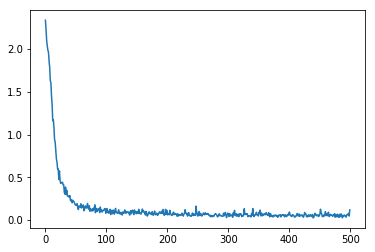

In [39]:
import matplotlib.pyplot as plt

print(total_evaluate())

plt.plot(all_losses)
plt.show()

## Save and load models

In [43]:
path = 'Data/Models/pos-tag_universal'

torch.save(model.state_dict(), path)

In [27]:
model = LSTMTagger(HIDDEN_DIM, HIDDEN_DIM2, len(tag_to_ix))
model.load_state_dict(torch.load(path))
model.eval()

LSTMTagger(
  (word_embeddings): Embedding(50806, 64)
  (lstm): LSTM(64, 128)
  (hidden2tag): Linear(in_features=128, out_features=19, bias=True)
)

## confusion matrix

In [40]:
all_categories = list(tag_to_ix)
n_categories = len(all_categories)

# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories) 

n_confusion = 1000
y_train = []
y_test = []
with torch.no_grad():
    for i in range(len(test_data)):
        try:
            
            sentence = test_data[i][0]
            
            sentence_in = np.empty((len(sentence), 500))
            for j in range(len(sentence)):
                sentence_in[j] = word_vectors[sentence[j]]

            sentence_in = torch.Tensor(sentence_in)
            sentence_in = sentence_in.view(len(sentence), 1, -1)

            output = model(sentence_in)

            # get top
            topv, topi = output.topk(1)
            true_values = prepare_sequence(test_data[i][1], tag_to_ix)

            for j in range(len(true_values)):
                confusion[true_values[j]][topi[j]] += 1 # инк ячейку
                y_train.append(topi[j].item())
                y_test.append(true_values[j].item())
        except RuntimeError:
            pass
            
normalize_confusion = torch.clone(confusion)
# Normalize 
for i in range(n_categories):
    normalize_confusion[i] = normalize_confusion[i] / normalize_confusion[i].sum()

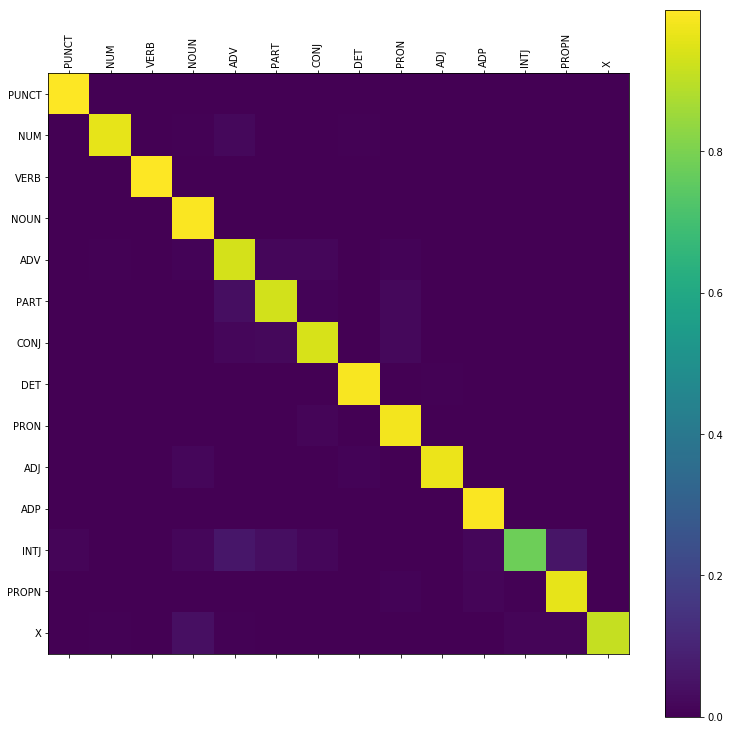

In [41]:
from matplotlib import ticker

# Set up plot
fig = plt.figure(figsize=(13, 13))
ax = fig.add_subplot(111)
cax = ax.matshow(normalize_confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

In [42]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

a = classification_report(y_test, y_train, target_names = [str(K) for K in list(tag_to_ix.keys())])

print(a)

              precision    recall  f1-score   support

       PUNCT       1.00      1.00      1.00     40332
         NUM       0.95      0.96      0.95      2618
        VERB       1.00      1.00      1.00     24509
        NOUN       0.99      0.99      0.99     42353
         ADV       0.94      0.94      0.94     12414
        PART       0.93      0.93      0.93      7477
        CONJ       0.96      0.94      0.95     12326
         DET       0.98      0.99      0.99      7632
        PRON       0.95      0.98      0.97     12505
         ADJ       0.99      0.97      0.98     13616
         ADP       1.00      1.00      1.00     15063
        INTJ       0.81      0.78      0.79       162
       PROPN       0.92      0.96      0.94       444
           X       0.93      0.91      0.92       834

   micro avg       0.98      0.98      0.98    192285
   macro avg       0.95      0.95      0.95    192285
weighted avg       0.98      0.98      0.98    192285

